Setup and Imports

In [1]:
# Complete Setup
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
import re
import os
import random
import h5py
import builtins
from pathlib import Path
from collections import defaultdict, Counter
from typing import List, Dict, Set, Any, Optional, Tuple

# TensorFlow/Keras
import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

# Scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)
random.seed(42)

# Quiet logging helper
QUIET = False
def log(*args, **kwargs):
    if not QUIET:
        builtins.print(*args, **kwargs)

def _quiet_print(*args, **kwargs):
    return None

print = _quiet_print

# Set paths
DATA_PATH = Path("../data/sample/usegalaxy_workflow_connections_2026-02-11_10-48-58.tsv")
PROJECT_ROOT = Path("..")
OUTPUT_DIR = Path("../models/transformer_tool_recommendation")
PROCESSED_DIR = Path("../data/processed")

# Create directories
OUTPUT_DIR.mkdir(exist_ok=True, parents=True)
PROCESSED_DIR.mkdir(exist_ok=True, parents=True)

2026-02-26 20:51:57.161156: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Data Loading and Initial Exploration

In [2]:
log("Loading workflow connections...")
df = pd.read_csv(DATA_PATH, sep='\t')

log(f"Dataset shape: {df.shape}")
log(f"Unique workflows: {df['workflow_id'].nunique()}")
log(f"Unique source tools: {df['source_tool'].nunique()}")
log(f"Unique target tools: {df['target_tool'].nunique()}")

workflow_stats = df.groupby('workflow_id').agg({
    'source_step_id': 'count',
    'source_tool': 'nunique'
}).rename(columns={'source_step_id': 'num_connections', 'source_tool': 'unique_tools'})

Loading workflow connections...
Dataset shape: (48598, 11)
Unique workflows: 2189
Unique source tools: 1437
Unique target tools: 1849


Tool ID Cleaning and Standardization

In [ ]:
import re
import pandas as pd

MAX_LEN = 25
CONTEXT_KEY_LENGTH = MAX_LEN

def is_input_node(tool_id: str) -> bool:
    if pd.isna(tool_id):
        return False
    value = str(tool_id).strip().lower()
    if value == "input":
        return True
    return value.startswith("input dataset") or value.startswith("input parameter") or value.startswith("input collection")

def is_parameter_node(tool_id: str) -> bool:
    if pd.isna(tool_id):
        return False
    value = str(tool_id).strip().lower()
    return value.startswith("input parameter")

def is_non_tool_label(tool_id: str, version: str) -> bool:
    if pd.isna(tool_id):
        return True
    version_value = str(version).strip().lower() if not pd.isna(version) else ""
    if version_value == "n/a":
        value = str(tool_id).strip()
        if " " in value and not is_input_node(value):
            return True
    return False

def clean_tool_id(tool_id: str) -> str:
    """
    Clean tool identifiers while preserving real tool identity.
    Avoid over-collapsing valid tool names.
    """
    if pd.isna(tool_id):
        return "<UNK>"
    tool_id = str(tool_id).strip()
    if is_input_node(tool_id):
        return "<INPUT_DATA>"
    if re.fullmatch(r"[a-f0-9]{32}", tool_id):
        return f"tool_{tool_id}"
    if "/" in tool_id:
        parts = tool_id.split("/")
        if len(parts) >= 2:
            tool_name = parts[-2]
        else:
            tool_name = parts[-1]
    else:
        tool_name = tool_id
    tool_name = re.sub(r"[^a-zA-Z0-9_]", "_", tool_name)
    tool_name = re.sub(r"_+", "_", tool_name).strip("_")
    return tool_name.lower() if tool_name else "unknown_tool"

rows_before = len(df)
source_param = df["source_tool"].apply(is_parameter_node)
target_param = df["target_tool"].apply(is_parameter_node)
source_version = df["source_tool_version"] if "source_tool_version" in df.columns else pd.Series(["n/a"] * len(df), index=df.index)
target_version = df["target_tool_version"] if "target_tool_version" in df.columns else pd.Series(["n/a"] * len(df), index=df.index)
source_non_tool = df.apply(lambda row: is_non_tool_label(row["source_tool"], source_version.loc[row.name]), axis=1)
target_non_tool = df.apply(lambda row: is_non_tool_label(row["target_tool"], target_version.loc[row.name]), axis=1)
target_input = df["target_tool"].apply(is_input_node)
drop_mask = source_param | target_param | source_non_tool | target_non_tool | target_input
df = df.loc[~drop_mask].copy()

df["source_tool_clean"] = df["source_tool"].apply(clean_tool_id)
df["target_tool_clean"] = df["target_tool"].apply(clean_tool_id)

version_cols = [col for col in ["source_tool_version", "target_tool_version"] if col in df.columns]
if version_cols:
    df = df.drop(columns=version_cols)
    print("Version columns dropped to prevent leakage.")
else:
    print("No version columns found; skipping drop.")

all_tools = set(df["source_tool_clean"]) | set(df["target_tool_clean"])
tool2id = {tool: idx for idx, tool in enumerate(sorted(all_tools))}
id2tool = {idx: tool for tool, idx in tool2id.items()}

input_count = (df["source_tool_clean"] == "<INPUT_DATA>").sum()


print(df["source_tool_clean"].value_counts().head(10))

print(df["target_tool_clean"].value_counts().head(10))

Workflow Sequence Generation

In [4]:
import networkx as nx

def build_workflow_sequences(workflow_df, min_seq_length=2, max_seq_length=25, max_paths_per_workflow=5000):
    """
    Build workflow sequences from DAGs with optimizations to prevent explosion.

    Features:
    - Preserves DAG branching.
    - Extracts root-to-leaf paths.
    - Converts step IDs to cleaned tools.
    - Removes consecutive duplicate tools.
    - Generates prefix sequences up to max_seq_length.
    - Limits total sequences per workflow for efficiency.
    """
    log("Building workflow sequences...")

    sequences = []
    workflow_stats = []

    for workflow_id, group in workflow_df.groupby("workflow_id"):
        # Build DAG
        G = nx.DiGraph()
        step_to_tool = {}

        for _, row in group.iterrows():
            s_id = str(row["source_step_id"])
            t_id = str(row["target_step_id"])
            s_tool = row["source_tool_clean"]
            t_tool = row["target_tool_clean"]

            G.add_edge(s_id, t_id)
            step_to_tool[s_id] = s_tool
            step_to_tool[t_id] = t_tool

        roots = [n for n in G.nodes if G.in_degree(n) == 0]
        leaves = [n for n in G.nodes if G.out_degree(n) == 0]

        workflow_sequence_count = 0

        # Extract paths with limits
        for root in roots:
            for leaf in leaves:
                try:
                    paths = nx.all_simple_paths(G, source=root, target=leaf)
                    for path_idx, path in enumerate(paths):
                        if path_idx >= max_paths_per_workflow:
                            break

                        # Map step IDs to tools
                        tool_sequence = [step_to_tool.get(n, "unknown_tool") for n in path]

                        # Remove consecutive duplicates
                        dedup_sequence = [tool for i, tool in enumerate(tool_sequence)
                                          if i == 0 or tool != tool_sequence[i-1]]

                        # Generate prefix sequences
                        for seq_len in range(min_seq_length, min(len(dedup_sequence), max_seq_length) + 1):
                            prefix_seq = dedup_sequence[:seq_len]
                            sequences.append(prefix_seq)
                            workflow_sequence_count += 1
                except nx.NetworkXNoPath:
                    continue

        workflow_stats.append({
            "workflow_id": workflow_id,
            "sequences_created": workflow_sequence_count,
            "connections": len(group),
            "nodes": len(G.nodes)
        })

    total_sequences = sum(stat["sequences_created"] for stat in workflow_stats)
    utilization = total_sequences / len(workflow_stats) if workflow_stats else 0

    log("Workflow sequence building complete")
    log(f"  Workflows processed: {len(workflow_stats)}")
    log(f"  Sequences generated: {total_sequences}")
    log(f"  Average sequences per workflow: {utilization:.1f}")

    return sequences, workflow_stats

# Apply sequence builder
sequences, workflow_stats = build_workflow_sequences(
    df,
    min_seq_length=2,
    max_seq_length=25,
    max_paths_per_workflow=5000  # prevents combinatorial explosion
)

Building workflow sequences...
Workflow sequence building complete
  Workflows processed: 2186
  Sequences generated: 371225
  Average sequences per workflow: 169.8


Vocabulary Creation with Frequency Analysis

In [71]:
from collections import Counter
import numpy as np

def create_vocabulary(sequences, min_frequency=3):
    """
    Create vocabulary according to paper methodology:
    - Uses already cleaned sequences.
    - Filters rare tools based on min_frequency.
    - Adds special tokens: <PAD>, <UNK>, <INPUT_DATA>.
    """
    # Flatten all tools
    all_tools = [tool for seq in sequences for tool in seq]
    tool_counts = Counter(all_tools)

    # Keep special tokens regardless of frequency
    special_tokens = ["<PAD>", "<UNK>", "<INPUT_DATA>"]

    # Filter tools by minimum frequency
    filtered_tools = {tool: count for tool, count in tool_counts.items()
                      if count >= min_frequency or tool in special_tokens}

    # Build vocabulary: special tokens first, then descending frequency
    vocab_list = special_tokens + [
        tool for tool, _ in sorted(filtered_tools.items(), key=lambda x: x[1], reverse=True)
        if tool not in special_tokens
    ]
    vocab = {tool: idx for idx, tool in enumerate(vocab_list)}
    reverse_vocab = {idx: tool for tool, idx in vocab.items()}

    # Sequence statistics
    input_sequences = [seq for seq in sequences if "<INPUT_DATA>" in seq]
    avg_seq_len = np.mean([len(seq) for seq in sequences]) if sequences else 0.0

    vocab_stats = {
        'total_vocab_size': len(vocab),
        'unique_tools': len(filtered_tools),
        'special_tokens': len(special_tokens),
        'input_data_index': vocab.get('<INPUT_DATA>', -1),
        'input_data_count': filtered_tools.get('<INPUT_DATA>', 0),
        'min_frequency': min_frequency,
        'total_sequences': len(sequences),
        'sequences_with_input': len(input_sequences),
        'avg_sequence_length': avg_seq_len
    }

    log("Vocabulary created")
    log(f"  Total vocabulary size: {vocab_stats['total_vocab_size']}")
    log(f"  Minimum frequency used: {min_frequency}")
    log(f"  Total sequences: {vocab_stats['total_sequences']}")
    log(f"  Average sequence length: {vocab_stats['avg_sequence_length']:.2f}")

    return vocab, reverse_vocab, filtered_tools, vocab_stats

# Apply vocabulary creation
vocab, reverse_vocab, tool_counts, vocab_stats = create_vocabulary(sequences, min_frequency=3)

Vocabulary created
  Total vocabulary size: 817
  Minimum frequency used: 3
  Total sequences: 371225
  Average sequence length: 5.96


In [40]:
MIN_TOOL_FREQUENCY = 3  # Only include tools appearing ≥3 times
SPECIAL_TOKENS = ["<PAD>", "<UNK>", "<INPUT_DATA>"]

def filter_vocabulary_by_frequency(vocab, tool_counts, min_freq=MIN_TOOL_FREQUENCY, special_tokens=SPECIAL_TOKENS):
    """Filter vocabulary to reduce extreme imbalance (paper-aligned)"""
    
    filtered_vocab = {}
    filtered_tool_counts = {}
    
    # Keep special tokens + tools with frequency ≥ min_freq
    for tool, idx in vocab.items():
        count = tool_counts.get(tool, 0)
        if tool in special_tokens or count >= min_freq:
            filtered_vocab[tool] = idx
            filtered_tool_counts[tool] = count
    
    # Frequency distribution
    freq_dist = {
        'very_rare': len([t for t, c in filtered_tool_counts.items() if t not in special_tokens and c <= 5]),
        'rare': len([t for t, c in filtered_tool_counts.items() if t not in special_tokens and 5 < c <= 20]),
        'medium': len([t for t, c in filtered_tool_counts.items() if t not in special_tokens and 20 < c <= 100]),
        'frequent': len([t for t, c in filtered_tool_counts.items() if t not in special_tokens and c > 100])
    }
    
    # Vocabulary stats
    vocab_stats = {
        'total_tools': len(filtered_vocab),
        'special_tokens': len([t for t in filtered_vocab if t in special_tokens]),
        'unique_tools': len([t for t in filtered_vocab if t not in special_tokens]),
        'input_data_token': '<INPUT_DATA>' in filtered_vocab,
        'input_data_index': filtered_vocab.get('<INPUT_DATA>', -1),
        'most_common': Counter(filtered_tool_counts).most_common(10),
        'frequency_distribution': freq_dist
    }
    
    # Print summary
    print(f"📊 Filtered Vocabulary Statistics:")
    print(f"  Total vocabulary size: {vocab_stats['total_tools']}")
    print(f"  Unique tools (excluding special): {vocab_stats['unique_tools']}")
    print(f"  Special tokens: {vocab_stats['special_tokens']}")
    if vocab_stats['input_data_token']:
        print(f"  Input data token index: {vocab_stats['input_data_index']}")
    print(f"  Most common tools: {vocab_stats['most_common']}")
    print(f"  Frequency distribution: {vocab_stats['frequency_distribution']}")
    
    return vocab, filtered_tool_counts, vocab_stats

Extract Valid Tool Connections

In [72]:
from collections import defaultdict, Counter
import numpy as np
from typing import List, Dict, Tuple

def extract_compatible_tools(sequences: List[List[str]], vocab: Dict[str, int]) -> Tuple[Dict[str, List[str]], Dict[str, any]]:
    """
    Extract all possible next tools for each tool in the cleaned sequences.

    Args:
        sequences: List of sequences (each sequence is a list of cleaned tool IDs)
        vocab: Vocabulary dictionary mapping tools to indices
    Returns:
        compatible_tools: Dict mapping each tool to a list of possible next tools
        connection_stats: Summary statistics for compatible tool connections
    """
    compatible_tools = defaultdict(set)
    tool_pairs_counter = Counter()

    for seq in sequences:
        for i in range(len(seq) - 1):
            current_tool = seq[i]
            next_tool = seq[i + 1]

            # Only consider tools present in the vocabulary
            if current_tool in vocab and next_tool in vocab:
                compatible_tools[current_tool].add(next_tool)
                tool_pairs_counter[f"{current_tool}->{next_tool}"] += 1

    # Convert sets to lists for consistency
    compatible_tools = {tool: sorted(list(next_tools)) for tool, next_tools in compatible_tools.items()}

    # Connection statistics
    next_tools_counts = [len(tools) for tools in compatible_tools.values()]
    connection_stats = {
        'total_tools_with_connections': len(compatible_tools),
        'avg_next_tools_per_tool': np.mean(next_tools_counts) if next_tools_counts else 0,
        'max_next_tools': max(next_tools_counts) if next_tools_counts else 0,
        'min_next_tools': min(next_tools_counts) if next_tools_counts else 0,
        'total_unique_pairs': len(tool_pairs_counter)
    }

    log("Compatible tools extracted")
    log(f"  Tools with connections: {connection_stats['total_tools_with_connections']}")
    log(f"  Total unique pairs: {connection_stats['total_unique_pairs']}")

    return compatible_tools, connection_stats

# Extract compatible tools using the cleaned sequences and filtered vocabulary
compatible_tools, connection_stats = extract_compatible_tools(sequences, vocab)

Compatible tools extracted
  Tools with connections: 652
  Total unique pairs: 3453


Multi-Label Target Creation

In [73]:
def create_multi_label_targets(sequences, vocab, compatible_tools, max_context_length=MAX_LEN, context_key_length=CONTEXT_KEY_LENGTH):
    """
    Create multi-label targets.

    Parameters:
    - sequences: list of sequences of cleaned tools
    - vocab: dict of valid tools
    - compatible_tools: dict of compatible successors for each tool
    - max_context_length: maximum context to consider for input
    - context_key_length: number of last tools to use in context key
    Returns:
    - input_target_pairs: dict mapping context_key -> list of possible next tools
    - target_statistics: Counter of how often each tool appears as target
    """
    input_target_pairs = defaultdict(set)
    target_statistics = Counter()

    for seq in sequences:
        seq_len = len(seq)
        for i in range(1, seq_len):
            context = seq[max(0, i - max_context_length):i]
            current_tool = seq[i]

            if current_tool not in vocab:
                continue

            context_key = "|".join(context[-context_key_length:])
            valid_next_tools = compatible_tools.get(context[-1], []) if context else [current_tool]
            if current_tool not in valid_next_tools:
                continue

            input_target_pairs[context_key].add(current_tool)
            target_statistics[current_tool] += 1

    input_target_pairs = {k: list(v) for k, v in input_target_pairs.items()}

    total_contexts = len(input_target_pairs)
    total_targets = sum(len(v) for v in input_target_pairs.values())
    log("Multi-label target creation complete")
    log(f"  Total unique contexts: {total_contexts}")
    log(f"  Total context-target pairs: {total_targets}")

    return input_target_pairs, target_statistics

# Apply target creation
input_target_pairs, target_stats = create_multi_label_targets(
    sequences, vocab, compatible_tools, max_context_length=MAX_LEN, context_key_length=CONTEXT_KEY_LENGTH
)

Multi-label target creation complete
  Total unique contexts: 11265
  Total context-target pairs: 17029


Negative Sampling

In [74]:
import random
from collections import defaultdict, Counter

def create_negative_samples(input_target_pairs, compatible_tools, vocab, negative_ratio=1.5):
    """
    Generate negative samples for multi-label workflow prediction.

    - For each context, sample tools NOT compatible with the last tool.
    - Avoid using context tools themselves as negatives.
    - Ensure negative:positive ratio ~= negative_ratio.
    - Special tokens are excluded from negatives.
    """
    all_tools = set(vocab.keys()) - {"<PAD>", "<UNK>", "<INPUT_DATA>"}
    negative_pairs = {}
    total_positive_targets = 0

    for context_str, positives in input_target_pairs.items():
        context_tools = context_str.split("|")
        if not context_tools:
            continue

        total_positive_targets += len(positives)
        last_tool = context_tools[-1]
        valid_next_tools = set(compatible_tools.get(last_tool, []))
        candidate_negatives = list(all_tools - valid_next_tools - set(context_tools))
        num_negatives = max(int(len(positives) * negative_ratio), 1)

        if len(candidate_negatives) >= num_negatives:
            sampled_negatives = random.sample(candidate_negatives, num_negatives)
        else:
            sampled_negatives = candidate_negatives

        if sampled_negatives:
            negative_pairs[context_str] = sampled_negatives

    total_negatives = sum(len(v) for v in negative_pairs.values())
    avg_negatives = total_negatives / total_positive_targets if total_positive_targets > 0 else 0
    log("Negative sampling complete")
    log(f"  Achieved ratio: 1:{avg_negatives:.2f}")

    return negative_pairs

def combine_positive_negative_pairs(input_target_pairs, negative_pairs):
    """
    Combine positive and negative samples into a unified dictionary.

    Output format:
    {context_str: {"positive": [...], "negative": [...]}}
    """
    combined_pairs = {}
    total_positives = 0
    total_negatives = 0

    for context, positives in input_target_pairs.items():
        combined_pairs[context] = {"positive": positives, "negative": []}
        total_positives += len(positives)

    for context, negatives in negative_pairs.items():
        if context in combined_pairs:
            combined_pairs[context]["negative"] = negatives
        else:
            combined_pairs[context] = {"positive": [], "negative": negatives}
        total_negatives += len(negatives)

    final_ratio = total_negatives / total_positives if total_positives > 0 else 0
    log("Combined dataset complete")
    log(f"  Final negative:positive ratio: 1:{final_ratio:.2f}")

    return combined_pairs

# Create negative samples
negative_pairs_3 = create_negative_samples(
    input_target_pairs, compatible_tools, vocab, negative_ratio=1.5
)

# Combine positives and negatives
combined_pairs_3 = combine_positive_negative_pairs(input_target_pairs, negative_pairs_3)

Negative sampling complete
  Achieved ratio: 1:1.21
Combined dataset complete
  Final negative:positive ratio: 1:1.21


Matrix Creation with Padding

In [75]:
import numpy as np

USE_COMPATIBLE_TARGETS = True
def create_training_matrices(combined_pairs, vocab, max_len=MAX_LEN, compatible_tools=None, include_compatible_targets=False):
    """
    Convert combined positive/negative samples to training matrices for multi-label workflow prediction.

    - Context sequences are encoded with clean vocabulary.
    - Left-padded to fixed length.
    - Positive targets are multi-hot encoded.
    - Optionally expand positives using compatible tools for the last context tool.
    - Negative targets are tracked but not encoded.
    """
    pad_idx = vocab["<PAD>"]
    unk_idx = vocab["<UNK>"]
    vocab_size = len(vocab)

    X_data, y_data, sample_info = [], [], []

    for context_str, sample in combined_pairs.items():
        context_tools = context_str.split("|")
        valid_context = [tool for tool in context_tools if tool in vocab]
        encoded_context = [vocab.get(tool, unk_idx) for tool in valid_context]
        if len(encoded_context) < max_len:
            encoded_context = [pad_idx] * (max_len - len(encoded_context)) + encoded_context
        else:
            encoded_context = encoded_context[-max_len:]

        target_vector = np.zeros(vocab_size, dtype=np.float32)
        for target_tool in sample["positive"]:
            if target_tool in vocab:
                target_vector[vocab[target_tool]] = 1.0

        if include_compatible_targets and compatible_tools and valid_context:
            last_tool = valid_context[-1]
            for next_tool in compatible_tools.get(last_tool, []):
                if next_tool in vocab:
                    target_vector[vocab[next_tool]] = 1.0

        X_data.append(encoded_context)
        y_data.append(target_vector)
        sample_info.append({
            "context_length": len(valid_context),
            "num_positives": len(sample["positive"]),
            "num_negatives": len(sample["negative"])
        })

    X_data = np.array(X_data, dtype=np.int32)
    y_data = np.array(y_data, dtype=np.float32)

    matrix_stats = {
        "input_shape": X_data.shape,
        "target_shape": y_data.shape,
        "vocab_size": vocab_size,
        "avg_targets_per_sample": np.mean(np.sum(y_data, axis=1)) if len(y_data) else 0.0,
        "max_targets_per_sample": np.max(np.sum(y_data, axis=1)) if len(y_data) else 0.0,
        "avg_context_length": np.mean([s["context_length"] for s in sample_info]) if sample_info else 0.0,
        "avg_positives_per_sample": np.mean([s["num_positives"] for s in sample_info]) if sample_info else 0.0,
        "avg_negatives_per_sample": np.mean([s["num_negatives"] for s in sample_info]) if sample_info else 0.0,
        "padding_ratio": np.mean(np.sum(X_data == pad_idx, axis=1) / max_len) if len(X_data) else 0.0
    }

    log("Training matrices created")
    log(f"  Input matrix shape: {matrix_stats['input_shape']}")
    log(f"  Target matrix shape: {matrix_stats['target_shape']}")
    log(f"  Vocabulary size: {matrix_stats['vocab_size']}")

    assert y_data.shape[1] == vocab_size, "Target matrix column mismatch with vocab size"

    return X_data, y_data, matrix_stats, sample_info

# Create matrices
X_data, y_data, matrix_stats, sample_info = create_training_matrices(
    combined_pairs_3, vocab, max_len=MAX_LEN, compatible_tools=compatible_tools, include_compatible_targets=USE_COMPATIBLE_TARGETS
)
label_counts = np.sum(y_data, axis=0)

Training matrices created
  Input matrix shape: (11265, 25)
  Target matrix shape: (11265, 817)
  Vocabulary size: 817


Class Weighting for Imbalanced Tools

In [76]:
def calculate_class_weights(label_counts, vocab, boost_factor=3.0):
    """
    Calculate class weights for multi-label workflow prediction.

    - Covers all tools in vocabulary.
    - Special tokens have predefined low weights.
    - Rare tools are boosted logarithmically.
    """
    class_weights = {}

    class_weights[vocab["<PAD>"]] = 0.0
    class_weights[vocab["<UNK>"]] = 0.0
    if "<INPUT_DATA>" in vocab:
        class_weights[vocab["<INPUT_DATA>"]] = 0.1

    max_count = float(np.max(label_counts)) if label_counts is not None and len(label_counts) > 0 else 1.0

    for tool_name, tool_idx in vocab.items():
        if tool_name in ["<PAD>", "<UNK>", "<INPUT_DATA>"]:
            continue

        count = float(label_counts[tool_idx]) if tool_idx < len(label_counts) else 1.0
        base_weight = np.log(max_count / (count + 1.0)) + 1.0

        if count <= 5:
            weight = base_weight * boost_factor
        elif count <= 20:
            weight = base_weight * (boost_factor / 2)
        else:
            weight = base_weight

        class_weights[tool_idx] = round(weight, 6)

    return class_weights

# Apply class weights calculation
class_weights = calculate_class_weights(label_counts, vocab, boost_factor=3.0)
log(f"Class weights computed: {len(class_weights)}")

Class weights computed: 817


Balanced Train/Test Split

In [77]:
from sklearn.model_selection import train_test_split

def balanced_train_val_test_split(
    X_data, y_data, train_ratio=0.7, val_ratio=0.15, vocab=None, random_state=42
):
    """
    Create a proper 70/15/15 train/validation/test split.
    
    - Left padding already handled in X_data.
    - Provides statistics per split.
    - Average targets and context lengths computed.
    """

    # Compute remaining ratio for test
    test_ratio = 1.0 - train_ratio - val_ratio

    # Step 1: Split train vs (val+test)
    X_train, X_temp, y_train, y_temp = train_test_split(
        X_data, y_data, test_size=(val_ratio + test_ratio),
        random_state=random_state, stratify=None
    )

    # Step 2: Split temp into val and test
    val_size_relative = val_ratio / (val_ratio + test_ratio)
    X_val, X_test, y_val, y_test = train_test_split(
        X_temp, y_temp, test_size=val_size_relative,
        random_state=random_state, stratify=None
    )

    # Function to compute statistics for each split
    def split_stats(X_split, y_split, name):
        pad_idx = vocab.get("<PAD>", 0) if vocab else 0
        total_samples = len(X_split)
        avg_targets = np.mean(np.sum(y_split, axis=1))
        positive_ratio = np.mean(np.sum(y_split > 0, axis=1) > 0)
        avg_context_length = np.mean(np.sum(X_split != pad_idx, axis=1))

        return {
            'split_name': name,
            'total_samples': total_samples,
            'avg_targets': avg_targets,
            'positive_ratio': positive_ratio,
            'avg_context_length': avg_context_length
        }

    # Compute stats
    stats_train = split_stats(X_train, y_train, "Training")
    stats_val   = split_stats(X_val, y_val, "Validation")
    stats_test  = split_stats(X_test, y_test, "Test")

    return X_train, X_val, X_test, y_train, y_val, y_test, {
        'train_samples': stats_train['total_samples'],
        'val_samples': stats_val['total_samples'],
        'test_samples': stats_test['total_samples'],
        'train_ratio': len(X_train)/len(X_data),
        'val_ratio': len(X_val)/len(X_data),
        'test_ratio': len(X_test)/len(X_data)
    }

# Execute the fixed split
X_train, X_val, X_test, y_train, y_val, y_test, split_stats = balanced_train_val_test_split(
    X_data, y_data, train_ratio=0.7, val_ratio=0.15, vocab=vocab
)
log(f"Split sizes: train={len(X_train)}, val={len(X_val)}, test={len(X_test)}")

Split sizes: train=7885, val=1690, test=1690


Transformer Architecture Definition

In [78]:
class TransformerBlock(Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1, attention_dropout=0.1):
        super(TransformerBlock, self).__init__()
        self.att = MultiHeadAttention(
            num_heads=num_heads,
            key_dim=embed_dim // num_heads,
            dropout=attention_dropout,
            kernel_initializer=tf.keras.initializers.GlorotUniform(),
            bias_initializer=tf.keras.initializers.Zeros()
        )
        self.ffn = tf.keras.Sequential([
            Dense(
                ff_dim,
                activation="gelu",
                kernel_initializer=tf.keras.initializers.HeNormal(),
                kernel_regularizer=tf.keras.regularizers.l2(1e-5)
            ),
            Dropout(rate),
            Dense(
                embed_dim,
                kernel_initializer=tf.keras.initializers.HeNormal(),
                kernel_regularizer=tf.keras.regularizers.l2(1e-5)
            )
        ])
        self.layernorm1 = LayerNormalization(epsilon=1e-6)
        self.layernorm2 = LayerNormalization(epsilon=1e-6)
        self.dropout1 = Dropout(rate)
        self.dropout2 = Dropout(rate)

    def call(self, inputs, training=None):
        attn_output = self.att(inputs, inputs, inputs, training=training)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1, training=training)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)

class TokenAndPositionEmbedding(Layer):
    def __init__(self, maxlen, vocab_size, embed_dim, dropout_rate=0.1):
        super(TokenAndPositionEmbedding, self).__init__()
        self.token_emb = Embedding(
            input_dim=vocab_size,
            output_dim=embed_dim,
            mask_zero=True,
            embeddings_initializer=tf.keras.initializers.TruncatedNormal(stddev=0.02),
            embeddings_regularizer=tf.keras.regularizers.l2(1e-6)
        )
        self.pos_emb = Embedding(
            input_dim=maxlen,
            output_dim=embed_dim,
            mask_zero=False,
            embeddings_initializer=tf.keras.initializers.TruncatedNormal(stddev=0.02)
        )
        self.dropout = Dropout(dropout_rate)

    def call(self, x, training=None):
        maxlen = tf.shape(x)[-1]
        positions = tf.range(start=0, limit=maxlen, delta=1)
        positions = self.pos_emb(positions)
        x = self.token_emb(x)
        embeddings = x + positions
        return self.dropout(embeddings, training=training)

def create_transformer_model(vocab_size, embed_dim=64, feed_forward_dim=128, max_len=MAX_LEN, dropout=0.4, n_heads=2, num_transformer_blocks=1, use_second_dense=False):
    """Compact transformer model for small datasets"""
    inputs = Input(shape=(max_len,), dtype=tf.int32, name="tool_sequence_input")
    embedding_layer = TokenAndPositionEmbedding(
        max_len, vocab_size, embed_dim, dropout_rate=dropout * 0.5
    )
    x = embedding_layer(inputs)

    for _ in range(num_transformer_blocks):
        x = TransformerBlock(
            embed_dim, n_heads, feed_forward_dim, dropout, attention_dropout=dropout * 0.5
        )(x)

    avg_pooled = GlobalAveragePooling1D(name="global_avg_pool")(x)
    max_pooled = GlobalMaxPooling1D(name="global_max_pool")(x)
    pooled = tf.keras.layers.Concatenate(name="pooled_features")([avg_pooled, max_pooled])
    pooled = Dropout(dropout)(pooled)
    dense1 = Dense(
        feed_forward_dim,
        activation="gelu",
        name="dense_1",
        kernel_regularizer=tf.keras.regularizers.l2(1e-5)
    )(pooled)
    dense1 = Dropout(dropout)(dense1)
    final_features = dense1

    outputs = Dense(
        vocab_size,
        activation="sigmoid",
        name="tool_predictions",
        kernel_initializer=tf.keras.initializers.GlorotUniform(),
        bias_initializer=tf.keras.initializers.Constant(-2.0),
        kernel_regularizer=tf.keras.regularizers.l2(1e-5)
    )(final_features)

    model = Model(inputs=inputs, outputs=outputs, name="compact_transformer_tool_recommender")
    return model

model = create_transformer_model(
    len(vocab), embed_dim=64, feed_forward_dim=128, max_len=MAX_LEN, dropout=0.4, n_heads=2, num_transformer_blocks=1, use_second_dense=False
 )
log(f"Model input shape: {model.input_shape}")
log(f"Model output shape: {model.output_shape}")

Model input shape: (None, 25)
Model output shape: (None, 817)


Loss Function with Class Weights

In [48]:
USE_FOCAL_LOSS = True

def compute_weighted_loss(y_true, y_pred, class_weights=None, epsilon=1e-7):
    """
    Multi-label binary cross-entropy with per-class weights.

    Args:
        y_true: Tensor of shape (batch_size, vocab_size), float32
        y_pred: Tensor of shape (batch_size, vocab_size), float32, in [0,1]
        class_weights: dict {class_index: weight}, or None
        epsilon: small constant for numerical stability
    Returns:
        scalar tensor: weighted BCE loss
    """

    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.clip_by_value(y_pred, epsilon, 1.0 - epsilon)
    bce = -(y_true * tf.math.log(y_pred) + (1.0 - y_true) * tf.math.log(1.0 - y_pred))

    if class_weights is not None:
        vocab_size = y_true.shape[-1]
        weight_array = np.array([class_weights.get(i, 1.0) for i in range(vocab_size)], dtype=np.float32)
        weight_tensor = tf.constant(weight_array, dtype=tf.float32)
        bce = bce * weight_tensor

    loss = tf.reduce_mean(tf.reduce_sum(bce, axis=-1))
    return loss

def compute_focal_loss(y_true, y_pred, class_weights=None, gamma=2.0, alpha=0.25, epsilon=1e-7):
    """
    Multi-label focal loss with optional per-class weights.
    """
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.clip_by_value(y_pred, epsilon, 1.0 - epsilon)

    pt = tf.where(tf.equal(y_true, 1.0), y_pred, 1.0 - y_pred)
    focal_factor = tf.pow(1.0 - pt, gamma)
    alpha_factor = tf.where(tf.equal(y_true, 1.0), alpha, 1.0 - alpha)
    loss = -alpha_factor * focal_factor * tf.math.log(pt)

    if class_weights is not None:
        vocab_size = y_true.shape[-1]
        weight_array = np.array([class_weights.get(i, 1.0) for i in range(vocab_size)], dtype=np.float32)
        weight_tensor = tf.constant(weight_array, dtype=tf.float32)
        loss = loss * weight_tensor

    return tf.reduce_mean(tf.reduce_sum(loss, axis=-1))

Model Compilation

In [79]:
from tensorflow.keras.optimizers import Adam
import tensorflow as tf

def compile_transformer_model(model, class_weights, learning_rate=0.0005):
    """
    Compile transformer model with weighted multi-label loss
    and standard multi-label metrics.
    """
    expected_vocab_size = len(class_weights)
    if model.output_shape[-1] != expected_vocab_size:
        raise ValueError(
            f"Model output size {model.output_shape[-1]} does not match vocab size {expected_vocab_size}"
        )

    if USE_FOCAL_LOSS:
        loss_fn = lambda y_true, y_pred: compute_focal_loss(
            y_true, y_pred, class_weights
        )
    else:
        loss_fn = lambda y_true, y_pred: compute_weighted_loss(
            y_true, y_pred, class_weights
        )

    model.compile(
        optimizer=Adam(learning_rate=learning_rate),
        loss=loss_fn,
        metrics=[
            tf.keras.metrics.BinaryAccuracy(name="binary_accuracy"),
            tf.keras.metrics.Precision(name="precision"),
            tf.keras.metrics.Recall(name="recall"),
            tf.keras.metrics.AUC(name="auc")
        ]
    )
    return model

def test_model_forward_pass(model, X_sample, y_sample, class_weights):
    """
    Run a small forward pass and compute loss to verify correctness.
    """
    try:
        predictions = model(X_sample, training=False)

        if USE_FOCAL_LOSS:
            _ = compute_focal_loss(
                y_sample, predictions, class_weights
            )
        else:
            _ = compute_weighted_loss(
                y_sample, predictions, class_weights
            )

        return True
    except Exception:
        return False

# --------- Run Verification and Compilation ---------
test_batch_size = 4
X_sample = X_train[:test_batch_size]
y_sample = y_train[:test_batch_size]

if test_model_forward_pass(model, X_sample, y_sample, class_weights):
    model = compile_transformer_model(model, class_weights, learning_rate=0.0005)
    log("Model is ready for training")
else:
    log("Model/data mismatch")

Model is ready for training


Balanced Sampling for Training

In [80]:
def create_balanced_sampler(y_train, vocab, min_samples_per_label=2):
    """
    Create a balanced sampler for multi-label training.
    Filters out special tokens and labels with insufficient samples.
    """
    # Special token indices
    pad_idx = vocab.get("<PAD>", -1)
    unk_idx = vocab.get("<UNK>", -1)
    input_idx = vocab.get("<INPUT_DATA>", -1)

    # Extract unique labels and their sample indices
    unique_labels, label_indices = get_unique_labels_filtered(
        y_train, exclude_tokens=[pad_idx, unk_idx, input_idx]
    )

    # Filter labels with enough samples
    filtered_labels = []
    filtered_indices = {}

    for label in unique_labels:
        indices = label_indices[label]
        if len(indices) >= min_samples_per_label:
            filtered_labels.append(label)
            filtered_indices[label] = indices

    return filtered_indices, filtered_labels

def get_unique_labels_filtered(y_data, exclude_tokens=None):
    """
    Extract unique labels from y_data, excluding specified token indices.
    Returns:
      - u_labels: list of unique label indices
      - labels_pos_dict: dict mapping label index -> list of sample indices
    """
    if exclude_tokens is None:
        exclude_tokens = []

    labels_list = []
    labels_pos_dict = {}

    for i, row in enumerate(y_data):
        label_positions = np.where(row > 0)[0]

        # Exclude special tokens
        filtered_labels = [l for l in label_positions if l not in exclude_tokens]

        labels_list.extend(filtered_labels)

        for l in filtered_labels:
            if l not in labels_pos_dict:
                labels_pos_dict[l] = []
            labels_pos_dict[l].append(i)

    # Deduplicate indices
    for l in labels_pos_dict:
        labels_pos_dict[l] = list(set(labels_pos_dict[l]))

    u_labels = list(set(labels_list))
    return u_labels, labels_pos_dict

# Create balanced sampler
label_to_indices, available_labels = create_balanced_sampler(y_train, vocab)
log(f"Available labels for sampling: {len(available_labels)}")

Available labels for sampling: 652


In [81]:
import numpy as np

def get_balanced_batch(X_train, y_train, label_to_indices, available_labels, batch_size=32, prev_selected_tools=None):
    """
    Generate a balanced mini-batch for multi-label training.

    Args:
        X_train (np.ndarray): Training input sequences.
        y_train (np.ndarray): Training multi-hot targets.
        label_to_indices (dict): Mapping from label index -> list of sample indices.
        available_labels (list): List of all labels available for sampling.
        batch_size (int): Number of samples in the batch.
        prev_selected_tools (list): Optional list of recently selected labels to reduce repetition.

    Returns:
        X_batch (np.ndarray): Input batch.
        y_batch (np.ndarray): Target batch.
        selected_labels (list): Labels selected for this batch.
    """

    if prev_selected_tools is None:
        prev_selected_tools = []

    # Exclude recently used labels to maximize exposure
    recent_window = prev_selected_tools[-batch_size*2:]
    valid_labels = [l for l in available_labels if l not in recent_window]

    # Fallback if not enough new labels
    if len(valid_labels) < batch_size:
        valid_labels = available_labels.copy()

    # Safety fallback: random sampling if something goes wrong
    if not valid_labels:
        indices = np.random.choice(len(X_train), size=batch_size, replace=False)
        return X_train[indices], y_train[indices], []

    # Randomly select labels for this batch
    selected_labels = np.random.choice(valid_labels, size=min(batch_size, len(valid_labels)), replace=False)

    # Pick one sample per selected label
    batch_indices = [np.random.choice(label_to_indices[label]) for label in selected_labels]

    # Convert to numpy array
    batch_indices = np.array(batch_indices, dtype=int)

    # Return batch data
    X_batch = X_train[batch_indices]
    y_batch = y_train[batch_indices]

    return X_batch, y_batch, selected_labels.tolist()

Training with Balanced Sampling

In [90]:
def train_model(model, X_train, y_train, X_val, y_val, label_to_indices, available_labels,
                class_weights, epochs=50, batch_size=64, patience=5, lr_schedule=True):
    """Enhanced training with consistent loss function and progress logging."""

    max_train_index = len(X_train) - 1
    filtered_label_to_indices = {}
    filtered_available_labels = []

    for label, indices in label_to_indices.items():
        valid_indices = [idx for idx in indices if idx <= max_train_index]
        if valid_indices:
            filtered_label_to_indices[label] = valid_indices
            filtered_available_labels.append(label)

    training_history = {
        "train_loss": [],
        "val_loss": [],
        "learning_rate": [],
        "batch_loss": []
    }

    best_val_loss = float("inf")
    patience_counter = 0
    best_weights = None

    num_train_samples = len(X_train)
    steps_per_epoch = max(1, num_train_samples // batch_size)

    log(f"Training data size: {num_train_samples}")
    log(f"Validation data size: {len(X_val)}")
    log(f"Steps per epoch: {steps_per_epoch}")
    log(f"Batch size: {batch_size}")

    if lr_schedule:
        initial_lr = float(model.optimizer.learning_rate.numpy())
        total_steps = max(1, steps_per_epoch * epochs)
        lr_scheduler = tf.keras.optimizers.schedules.CosineDecay(
            initial_learning_rate=initial_lr,
            decay_steps=total_steps
        )
        model.optimizer.learning_rate = lr_scheduler

    if USE_FOCAL_LOSS:
        loss_fn = lambda y_true, y_pred: compute_focal_loss(
            y_true, y_pred, class_weights
        )
    else:
        loss_fn = lambda y_true, y_pred: compute_weighted_loss(
            y_true, y_pred, class_weights
        )

    for epoch in range(epochs):
        epoch_loss = 0
        num_batches = 0
        prev_selected_tools = []
        batch_losses = []

        for _ in range(steps_per_epoch):
            try:
                X_batch, y_batch, selected_tools = get_balanced_batch(
                    X_train, y_train, filtered_label_to_indices, filtered_available_labels,
                    batch_size, prev_selected_tools
                )

                with tf.GradientTape() as tape:
                    predictions = model(X_batch, training=True)
                    loss = loss_fn(y_batch, predictions)

                gradients = tape.gradient(loss, model.trainable_variables)
                gradients, _ = tf.clip_by_global_norm(gradients, 1.0)
                model.optimizer.apply_gradients(zip(gradients, model.trainable_variables))

                epoch_loss += loss
                batch_losses.append(loss.numpy())
                num_batches += 1
                prev_selected_tools = selected_tools

            except Exception:
                batch_indices = np.random.choice(
                    len(X_train),
                    size=min(batch_size, len(X_train)),
                    replace=False
                )
                X_batch = X_train[batch_indices]
                y_batch = y_train[batch_indices]

                with tf.GradientTape() as tape:
                    predictions = model(X_batch, training=True)
                    loss = loss_fn(y_batch, predictions)

                gradients = tape.gradient(loss, model.trainable_variables)
                gradients, _ = tf.clip_by_global_norm(gradients, 1.0)
                model.optimizer.apply_gradients(zip(gradients, model.trainable_variables))

                epoch_loss += loss
                batch_losses.append(loss.numpy())
                num_batches += 1

        avg_train_loss = epoch_loss / num_batches if num_batches > 0 else 0
        val_predictions = model(X_val, training=False)
        val_loss = loss_fn(y_val, val_predictions)

        lr_value = model.optimizer.learning_rate
        if callable(lr_value):
            current_lr = float(lr_value(model.optimizer.iterations).numpy())
        else:
            current_lr = float(tf.keras.backend.get_value(lr_value))

        avg_train_loss_value = float(avg_train_loss.numpy()) if hasattr(avg_train_loss, "numpy") else float(avg_train_loss)
        val_loss_value = float(val_loss.numpy()) if hasattr(val_loss, "numpy") else float(val_loss)

        training_history["train_loss"].append(avg_train_loss_value)
        training_history["val_loss"].append(val_loss_value)
        training_history["learning_rate"].append(current_lr)
        training_history["batch_loss"].extend(batch_losses)

        log(f"Epoch {epoch:>3} | Train Loss: {avg_train_loss_value:.4f} | Val Loss: {val_loss_value:.4f} | LR: {current_lr:.6f}")

        if val_loss_value < best_val_loss:
            best_val_loss = val_loss_value
            patience_counter = 0
            best_weights = model.get_weights()
            log(f"  New best model saved! Val Loss: {val_loss_value:.4f}")
        else:
            patience_counter += 1
            log(f"  Patience: {patience_counter}/{patience}")

        if patience_counter >= patience:
            if best_weights is not None:
                model.set_weights(best_weights)
            log(f"Early stopping at epoch {epoch}")
            break

    log("Training complete")
    return training_history, X_val, y_val

history, X_val_out, y_val_out = train_model(
    model, X_train, y_train, X_val, y_val,
    label_to_indices, available_labels, class_weights
)

Training data size: 7885
Validation data size: 1690
Steps per epoch: 123
Batch size: 64
Epoch   0 | Train Loss: 23.0222 | Val Loss: 14.4209 | LR: 0.000482
  New best model saved! Val Loss: 14.4209
Epoch   1 | Train Loss: 21.6637 | Val Loss: 12.8147 | LR: 0.000477
  New best model saved! Val Loss: 12.8147
Epoch   2 | Train Loss: 19.9402 | Val Loss: 11.7841 | LR: 0.000471
  New best model saved! Val Loss: 11.7841
Epoch   3 | Train Loss: 18.2055 | Val Loss: 10.7480 | LR: 0.000464
  New best model saved! Val Loss: 10.7480
Epoch   4 | Train Loss: 16.6036 | Val Loss: 9.7653 | LR: 0.000456
  New best model saved! Val Loss: 9.7653
Epoch   5 | Train Loss: 15.2128 | Val Loss: 8.8537 | LR: 0.000448
  New best model saved! Val Loss: 8.8537
Epoch   6 | Train Loss: 13.8913 | Val Loss: 8.0921 | LR: 0.000438
  New best model saved! Val Loss: 8.0921
Epoch   7 | Train Loss: 12.9365 | Val Loss: 7.5646 | LR: 0.000428
  New best model saved! Val Loss: 7.5646
Epoch   8 | Train Loss: 11.8966 | Val Loss: 7.03

In [91]:
import numpy as np

def sweep_thresholds_k(model, X_val, y_val, thresholds=None, k_values=None):
    if thresholds is None:
        thresholds = [0.1, 0.2, 0.3, 0.4, 0.5]
    if k_values is None:
        k_values = [3, 5, 10]

    y_pred_probs = model.predict(X_val, verbose=0)
    best = {"precision_at_k": -1.0}

    for k in k_values:
        for t in thresholds:
            precision_at_k = []
            recall_at_k = []
            for i in range(len(y_val)):
                true_labels = np.where(y_val[i] == 1)[0]
                if len(true_labels) == 0:
                    continue
                top_k = np.argsort(y_pred_probs[i])[-k:]
                correct = len(set(top_k) & set(true_labels))
                precision_at_k.append(correct / k)
                recall_at_k.append(correct / len(true_labels))
            avg_p = float(np.mean(precision_at_k)) if precision_at_k else 0.0
            avg_r = float(np.mean(recall_at_k)) if recall_at_k else 0.0
            if avg_p > best["precision_at_k"]:
                best = {
                    "k": k,
                    "threshold": t,
                    "precision_at_k": avg_p,
                    "recall_at_k": avg_r
                }
    log(f"Best sweep result: {best}")
    return best

best_sweep = sweep_thresholds_k(model, X_val_out, y_val_out)

Best sweep result: {'k': 3, 'threshold': 0.1, 'precision_at_k': 0.678698224852071, 'recall_at_k': 0.29531545783598806}


Training History Visualization

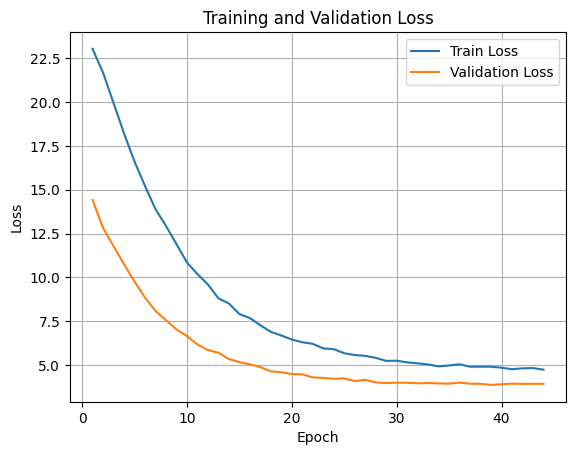

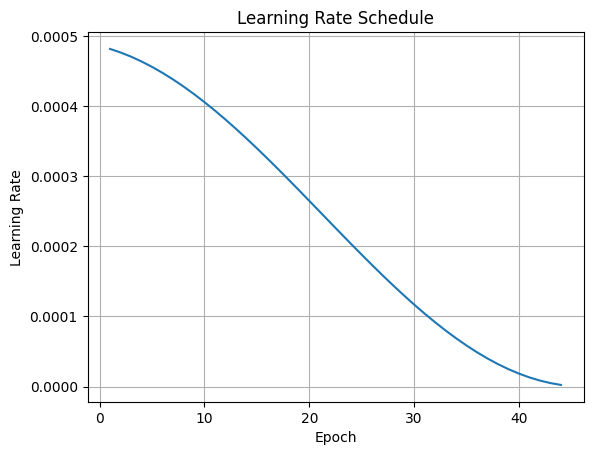

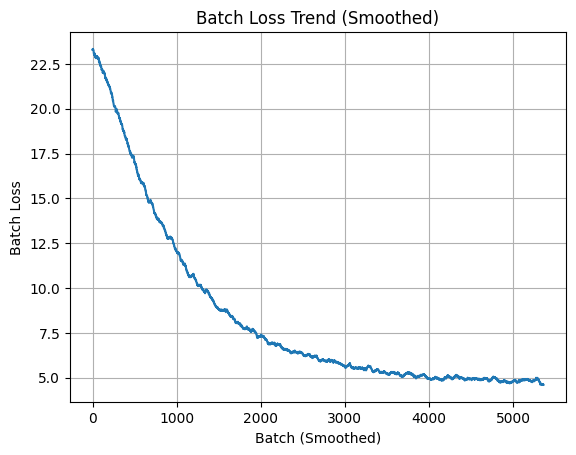

In [92]:
import matplotlib.pyplot as plt
import numpy as np

def plot_training_history(history):
    """
    Visualize training history including:
    - Training loss
    - Validation loss
    - Learning rate
    - Batch loss trend
    """
    epochs = range(1, len(history.get("train_loss", [])) + 1)

    # --------- Plot Train & Validation Loss ---------
    plt.figure()
    if "train_loss" in history:
        plt.plot(epochs, history["train_loss"], label="Train Loss")
    if "val_loss" in history:
        plt.plot(epochs, history["val_loss"], label="Validation Loss")

    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Training and Validation Loss")
    plt.legend()
    plt.grid(True)
    plt.show()

    # --------- Plot Learning Rate ---------
    if "learning_rate" in history:
        plt.figure()
        plt.plot(epochs, history["learning_rate"])
        plt.xlabel("Epoch")
        plt.ylabel("Learning Rate")
        plt.title("Learning Rate Schedule")
        plt.grid(True)
        plt.show()

    # --------- Plot Batch Loss Trend (Smoothed) ---------
    if "batch_loss" in history and len(history["batch_loss"]) > 0:
        batch_losses = np.array(history["batch_loss"])

        # Smooth batch loss using moving average
        window = min(50, len(batch_losses))
        if window > 1:
            smoothed = np.convolve(batch_losses, np.ones(window)/window, mode="valid")
        else:
            smoothed = batch_losses

        plt.figure()
        plt.plot(smoothed)
        plt.xlabel("Batch (Smoothed)")
        plt.ylabel("Batch Loss")
        plt.title("Batch Loss Trend (Smoothed)")
        plt.grid(True)
        plt.show()

plot_training_history(history)

Comprehensive Evaluation Metrics

In [95]:
import numpy as np
from sklearn.metrics import f1_score, precision_score, recall_score

def evaluate_model(model, X_test, y_test, threshold=0.1, k=3):
    """
    Evaluate multi-label model performance.

    Metrics:
    - Micro F1
    - Macro F1
    - Precision
    - Recall
    - Precision@k
    - Recall@k
    """
    # Get predictions
    y_pred_probs = model.predict(X_test, verbose=0)

    # Apply threshold
    y_pred_binary = (y_pred_probs >= threshold).astype(int)

    # -------- Standard Multi-Label Metrics --------
    micro_f1 = f1_score(y_test, y_pred_binary, average="micro", zero_division=0)
    macro_f1 = f1_score(y_test, y_pred_binary, average="macro", zero_division=0)

    precision = precision_score(y_test, y_pred_binary, average="micro", zero_division=0)
    recall = recall_score(y_test, y_pred_binary, average="micro", zero_division=0)

    # -------- Precision@k and Recall@k --------
    precision_at_k = []
    recall_at_k = []

    for i in range(len(y_test)):
        true_labels = np.where(y_test[i] == 1)[0]

        # Top-k predicted labels
        top_k = np.argsort(y_pred_probs[i])[-k:]

        if len(true_labels) == 0:
            continue

        correct = len(set(top_k) & set(true_labels))

        precision_at_k.append(correct / k)
        recall_at_k.append(correct / len(true_labels))

    avg_precision_at_k = np.mean(precision_at_k)
    avg_recall_at_k = np.mean(recall_at_k)

    # -------- Print Results --------
    log("Evaluation Results")
    log(f"  Micro F1:       {micro_f1:.4f}")
    log(f"  Macro F1:       {macro_f1:.4f}")
    log(f"  Precision:      {precision:.4f}")
    log(f"  Recall:         {recall:.4f}")
    log(f"  Precision@{k}:   {avg_precision_at_k:.4f}")
    log(f"  Recall@{k}:      {avg_recall_at_k:.4f}")

    results = {
        "micro_f1": micro_f1,
        "macro_f1": macro_f1,
        "precision": precision,
        "recall": recall,
        f"precision@{k}": avg_precision_at_k,
        f"recall@{k}": avg_recall_at_k,
    }

    return results

results = evaluate_model(model, X_val_out, y_val_out, threshold=0.5, k=10)

Evaluation Results
  Micro F1:       0.7835
  Macro F1:       0.4666
  Precision:      0.9514
  Recall:         0.6659
  Precision@10:   0.5202
  Recall@10:      0.5389


In [96]:
import numpy as np

def sample_balanced_test_batch(X_test, y_test, batch_size=1000):
    """Sample one example per label until batch_size (repo-style)."""
    u_labels, label_indices = get_unique_labels_filtered(y_test, exclude_tokens=[])
    if not u_labels:
        return X_test[:0], y_test[:0]
    labels = u_labels.copy()
    np.random.shuffle(labels)
    selected = []
    for label in labels:
        indices = label_indices[label]
        if indices:
            selected.append(np.random.choice(indices))
        if len(selected) >= batch_size:
            break
    selected = np.array(list(dict.fromkeys(selected)), dtype=int)
    return X_test[selected], y_test[selected]

def evaluate_model_dynamic_k(model, X_test, y_test, trained_labels=None, batch_size=1000):
    """Compute precision and recall with k = number of true labels (repo-style)."""
    X_batch, y_batch = sample_balanced_test_batch(X_test, y_test, batch_size=batch_size)
    if len(X_batch) == 0:
        return {"precision_dynamic_k": 0.0, "recall_dynamic_k": 0.0}

    y_pred = model.predict(X_batch, verbose=0)
    precision_scores = []
    recall_scores = []

    trained_labels_set = set(trained_labels) if trained_labels is not None else None
    for i in range(len(y_batch)):
        true_labels = np.where(y_batch[i] == 1)[0]
        if trained_labels_set is not None:
            true_labels = [t for t in true_labels if t in trained_labels_set]
        if len(true_labels) == 0:
            continue
        k = len(true_labels)
        top_k = np.argsort(y_pred[i])[-k:]
        correct = len(set(top_k) & set(true_labels))
        precision_scores.append(correct / k)
        recall_scores.append(correct / len(true_labels))

    precision_dynamic_k = float(np.mean(precision_scores)) if precision_scores else 0.0
    recall_dynamic_k = float(np.mean(recall_scores)) if recall_scores else 0.0
    log(f"Repo-style Precision@k (k = |true labels|): {precision_dynamic_k:.4f}")
    log(f"Repo-style Recall@k (k = |true labels|): {recall_dynamic_k:.4f}")
    return {
        "precision_dynamic_k": precision_dynamic_k,
        "recall_dynamic_k": recall_dynamic_k
    }

dynamic_k_results = evaluate_model_dynamic_k(
    model, X_val_out, y_val_out, trained_labels=available_labels, batch_size=1000
)

Repo-style Precision@k (k = |true labels|): 0.7627
Repo-style Recall@k (k = |true labels|): 0.7627


Low-Frequency Tool Evaluation

In [97]:
import os
import json
import pickle

def save_model_and_metadata(model, vocab, class_weights, training_history, save_dir="Results"):
    """
    Save the trained transformer model along with vocabulary,
    class weights, and training history.
    """
    
    os.makedirs(save_dir, exist_ok=True)
    
    # 1 Save TensorFlow model
    model_path = os.path.join(save_dir, "transformer_model.h5")
    model.save(model_path, include_optimizer=True)
    log(f"Model saved to: {model_path}")
    
    # 2 Save vocabulary
    vocab_path = os.path.join(save_dir, "vocab.json")
    with open(vocab_path, "w") as f:
        json.dump(vocab, f)
    log(f"Vocabulary saved to: {vocab_path}")
    
    # 3 Save class weights
    class_weights_path = os.path.join(save_dir, "class_weights.pkl")
    with open(class_weights_path, "wb") as f:
        pickle.dump(class_weights, f)
    log(f"Class weights saved to: {class_weights_path}")
    
    # 4 Save training history
    history_path = os.path.join(save_dir, "training_history.pkl")
    with open(history_path, "wb") as f:
        pickle.dump(training_history, f)
    log(f"Training history saved to: {history_path}")
    
    log(f"Artifacts saved in directory: {save_dir}")
    return save_dir
save_model_and_metadata(model, vocab, class_weights, history)


Model saved to: Results/transformer_model.h5
Vocabulary saved to: Results/vocab.json
Class weights saved to: Results/class_weights.pkl
Training history saved to: Results/training_history.pkl
Artifacts saved in directory: Results


'Results'

In [87]:
import os
import pickle

def save_processed_data(X_train, y_train, X_val, y_val, X_test, y_test,
                        label_to_indices, available_labels, reverse_vocab,
                        save_dir="processed_data"):
    """
    Save preprocessed data, label mappings, and reverse vocabulary
    for reproducible training and evaluation.
    """
    os.makedirs(save_dir, exist_ok=True)
    
    # Save train/val/test arrays
    np.save(os.path.join(save_dir, "X_train.npy"), X_train)
    np.save(os.path.join(save_dir, "y_train.npy"), y_train)
    np.save(os.path.join(save_dir, "X_val.npy"), X_val)
    np.save(os.path.join(save_dir, "y_val.npy"), y_val)
    np.save(os.path.join(save_dir, "X_test.npy"), X_test)
    np.save(os.path.join(save_dir, "y_test.npy"), y_test)
    
    # Save label_to_indices mapping
    with open(os.path.join(save_dir, "label_to_indices.pkl"), "wb") as f:
        pickle.dump(label_to_indices, f)
    
    # Save available labels list
    with open(os.path.join(save_dir, "available_labels.pkl"), "wb") as f:
        pickle.dump(available_labels, f)
    
    # Save reverse vocabulary
    with open(os.path.join(save_dir, "reverse_vocab.pkl"), "wb") as f:
        pickle.dump(reverse_vocab, f)
    
    log(f"Processed data saved to {save_dir}")
    return save_dir
save_processed_data(X_train, y_train, X_val, y_val, X_test, y_test,
                        label_to_indices, available_labels, reverse_vocab)

Processed data saved to processed_data


'processed_data'

Tool Recommendation Interface

In [99]:
def recommend_next_tools(context_tools, vocab, reverse_vocab, model, top_k=5, max_len=MAX_LEN):
    """Recommend next tools given context"""

    def clean_and_encode_tool(tool_name):
        """Clean and encode single tool"""
        cleaned_tool = clean_tool_id(tool_name)
        return vocab.get(cleaned_tool, vocab["<UNK>"])

    if isinstance(context_tools, str):
        context_tools = [tool.strip() for tool in context_tools.split(",")]

    encoded_context = [clean_and_encode_tool(tool) for tool in context_tools]

    if len(encoded_context) < max_len:
        encoded_context = [vocab["<PAD>"]] * (max_len - len(encoded_context)) + encoded_context
    else:
        encoded_context = encoded_context[-max_len:]

    input_tensor = np.array([encoded_context])
    predictions = model.predict(input_tensor, verbose=0)[0]

    top_k_indices = np.argsort(predictions)[-top_k:][::-1]

    recommendations = []
    for idx in top_k_indices:
        tool_name = reverse_vocab.get(idx, "<UNK>")
        confidence = float(predictions[idx])
        recommendations.append({
            "tool": tool_name,
            "confidence": confidence,
            "tool_index": idx
        })

    return recommendations

def format_recommendations(recommendations, max_items=10):
    return [
        {
            "rank": i + 1,
            "tool": rec["tool"],
            "confidence": round(rec["confidence"], 6),
            "tool_index": rec["tool_index"]
        }
        for i, rec in enumerate(recommendations[:max_items])
    ]

# Example usage
example_contexts = [
    ["tool_3d54e34c"],
    ["tool_3d54e34c", "tool_80adb2020"],
    ["tool_3d54e34c", "tool_80adb2020", "tool_1b0a9f7e"],
    ["tool_3d54e34c", "tool_80adb2020", "tool_1b0a9f7e", "tool_5f2d1a4b"],
    ["tool_3d54e34c", "tool_80adb2020", "tool_1b0a9f7e", "tool_5f2d1a4b", "tool_6c9f2e10"],
    "tool_3d54e34c, tool_80adb2020, tool_1b0a9f7e"
 ]

for idx, context in enumerate(example_contexts, start=1):
    recs = recommend_next_tools(context, vocab, reverse_vocab, model, top_k=10)
    log(f"Example {idx} context: {context}")
    log(format_recommendations(recs))

Example 1 context: ['tool_3d54e34c']
[{'rank': 1, 'tool': 'multiqc', 'confidence': 0.209338, 'tool_index': np.int64(66)}, {'rank': 2, 'tool': 'merge_collection', 'confidence': 0.202943, 'tool_index': np.int64(130)}, {'rank': 3, 'tool': 'jbrowse', 'confidence': 0.196438, 'tool_index': np.int64(366)}, {'rank': 4, 'tool': 'checkm2', 'confidence': 0.190802, 'tool_index': np.int64(464)}, {'rank': 5, 'tool': 'fastp', 'confidence': 0.183559, 'tool_index': np.int64(78)}, {'rank': 6, 'tool': 'msgfplusadapter', 'confidence': 0.179638, 'tool_index': np.int64(426)}, {'rank': 7, 'tool': 'metaprosip', 'confidence': 0.168936, 'tool_index': np.int64(545)}, {'rank': 8, 'tool': 'fastqc', 'confidence': 0.1677, 'tool_index': np.int64(105)}, {'rank': 9, 'tool': 'qiime2_demux_summarize', 'confidence': 0.165062, 'tool_index': np.int64(557)}, {'rank': 10, 'tool': 'lofreq_indelqual', 'confidence': 0.164948, 'tool_index': np.int64(120)}]
Example 2 context: ['tool_3d54e34c', 'tool_80adb2020']
[{'rank': 1, 'tool'